# Attempt 2
- This version is based on the one found here 
- 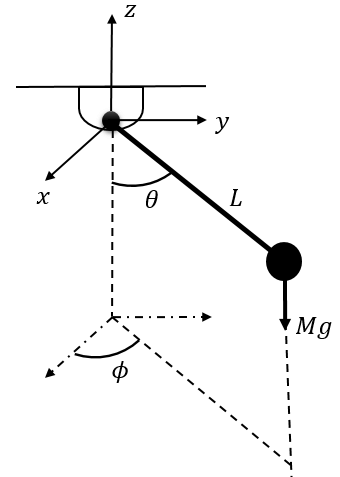

# Rotary Pendulum
- This attempt is based on first principals
- I used relative angles, if other wise just change the variables tht1 to th2 and pht1 to ph2
- [x] need to fix angular velocities
- Can now use this to set rotary pendulum by making $\theta_1 = \frac{\pi}{2}$ and making $\theta_2 = \frac{\pi}{2}$

In [ ]:
# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# symbols-----------------------------------------------------------------------------
# system parameters
X0, Y0, Z0 = sym.symbols(['X0','Y0', 'Z0']) # Origin
g = sym.symbols('g')

#---------------------Link parameters--------------------------------------------------------
# [mass, length, inertia]
m1, l1, In1 = sym.symbols(['m_1', 'l_1', 'I_1']) #Link 1
m2, l2, In2 = sym.symbols(['m_2', 'l_2', 'I_2']) #Link 2

# --------------------generalized coordinates
#th1, dth1, ddth1 = sym.symbols(['\\theta_{1}', '\\dot{\\theta_{1}}', '\\ddot{\\theta_{1}}'])
#th2, dth2, ddth2 = sym.symbols(['\\theta_{2}', '\\dot{\\theta_{2}}', '\\ddot{\\theta_{2}}'])
ph1, dph1, ddph1 = sym.symbols([  '\\phi_{1}',   '\\dot{\\phi_{1}}', '  \\ddot{\\phi_{1}}'])
ph2, dph2, ddph2 = sym.symbols([  '\\phi_{2}',   '\\dot{\\phi_{2}}', '  \\ddot{\\phi_{2}}'])

q   = sym.Matrix([  [ph1],   [ph2]]) #group into matrices
dq  = sym.Matrix([ [dph1],  [dph2]])
ddq = sym.Matrix([[ddph1], [ddph2]])

# fix th1 and th2
th1 = np.pi/2
th2 = 0

# Angles are not absolute, their from their parents
tht1 = th1+th2-th1
pht1 = ph1+ph2-ph1

#Positiions-----------------------------------------------------------------------------
## Link 1
x1 = X0 + l1*sym.sin(th1)*sym.cos(ph1)/2
y1 = Y0 - l1*sym.sin(th1)*sym.sin(ph1)/2
z1 = Z0 - l1*sym.cos(th1)/2

## Link 2
x2 = x1*2 + l2*sym.sin(tht1)*sym.cos(pht1)/2 - X0
y2 = y1*2 - l2*sym.sin(tht1)*sym.sin(pht1)/2 - Y0
z2 = z1*2 - l2*sym.cos(tht1)/2 - Z0

r1 = sym.simplify(sym.Matrix([x1, y1, z1]))
r2 = sym.simplify(sym.Matrix([x2, y2, z2]))
#display(r1,r2)

#Velocities----------------------------------------------------------------------------
## ------------linear velocities-------------------------------------------------------
dr1 = r1.jacobian(q)*dq
dr2 = r2.jacobian(q)*dq
#display(dr1, dr2)

## ------------angular velocities------------------------------------------------------
w1 = sym.Matrix([0, 0, dph1])
w2 = sym.Matrix([0, 0, dph2])


#Energies------------------------------------------------------------------------------
## ------------kinetic
T1 = 1/2 * m1 * dr1.T*dr1
T2 = 1/2 * m2 * dr2.T*dr2
T = sym.Matrix([sym.simplify(T1+T2)])


## -------------potential--------------------------------------------------------------
V1 = m1*g*z1
V2 = m2*g*z2
V = sym.Matrix([sym.simplify(V1+V2)])

# Lagrangian
Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = T.jacobian(q) # partial of T in q

# term 4
Lg4 = V.jacobian(q) # partial of U in q

#combine
EOM = Lg1 - Lg3 + Lg4
display(r1, r2)

In [ ]:
#initial conditions

ph10 = np.pi/2
ph20 = 0

dph10 = 0
dph20 = 0

h = 0.01

#parameters
X0val = 0
Y0val = 0
Z0val = 0
l1val = 1
l2val = 1

parameter_values = [(X0,X0val),(Y0,Y0val),(g,9.81),(m1,1),(m2,1),(l1,l1val),(l2,l2val),(In1,0.08),(In2,0.08)]

ph1ar = [ph10]
ph2ar = [ph20]

dph1ar = [dph10]
dph2ar = [dph20]

N = 100
for i in range(1,N):
    # substitute parameter values and previous conditions into the EOM 
    past = [(ph1,ph1ar[i-1]),(ph2,ph2ar[i-1]), 
            (dph1,dph1ar[i-1]),(dph2,dph2ar[i-1])]
    EOM_sub = EOM.subs(parameter_values).subs(past)
    display(EOM_sub)
    
    # solve for the acceleration
    acc = sym.solve(EOM_sub,[ddph1, ddph2])
    display(acc)
    # integrate for the next velocity and position
    dph1ar.append(float(dph1ar[i-1]+h*acc[ddph1]))
    dph2ar.append(float(dph2ar[i-1]+h*acc[ddph2]))
    
    ph1ar.append(float(ph1ar[i-1]+h*dph1ar[i]))
    ph2ar.append(float(ph2ar[i-1]+h*dph2ar[i]))

print(ph1ar)

## 3D and axes view

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

# Create the figure and subplots for XY, XZ, YZ planes, and a 3D plot
fig = plt.figure(figsize=(20, 5))
ax_xy = fig.add_subplot(141)  # XY Plane
ax_xz = fig.add_subplot(142)  # XZ Plane
ax_yz = fig.add_subplot(143)  # YZ Plane
ax_3d = fig.add_subplot(144, projection='3d')  # 3D plot

def plot_pendulum(i, th1_in, th2_in, ax_xy, ax_xz, ax_yz, ax_3d, ph1_in, ph2_in):  
    # Clear previous plots
    ax_xy.clear()
    ax_xz.clear()
    ax_yz.clear()
    ax_3d.clear()
    
    # Set limits and titles for each axis
    ax_xy.set_xlim([-4, 4])
    ax_xy.set_ylim([-4, 4])
    ax_xy.set_title('XY Plane')
    
    ax_xz.set_xlim([-4, 4])
    ax_xz.set_ylim([-4, 4])
    ax_xz.set_title('XZ Plane')
    
    ax_yz.set_xlim([-4, 4])
    ax_yz.set_ylim([-4, 4])
    ax_yz.set_title('YZ Plane')
    
    ax_3d.set_xlim([-4, 4])
    ax_3d.set_ylim([-4, 4])
    ax_3d.set_zlim([-4, 4])
    ax_3d.set_title('3D View')
    
    # Calculate positions for the pendulum
    L1bottomx = X0val + l1val * np.sin(th1_in[i]) * np.cos(ph1_in[i])
    L1bottomy = Y0val - l1val * np.sin(th1_in[i]) * np.sin(ph1_in[i])
    L1bottomz = Z0val - l1val * np.cos(th1_in[i])

    L2bottomx = L1bottomx + l2val * np.sin(th1_in[i] + th2_in[i]) * np.cos(ph1_in[i] + ph2_in[i])
    L2bottomy = L1bottomy - l2val * np.sin(th1_in[i] + th2_in[i]) * np.sin(ph1_in[i] + ph2_in[i])
    L2bottomz = L1bottomz - l2val * np.cos(th1_in[i] + th2_in[i])

    # Plot in XY Plane
    ax_xy.plot([X0val, L1bottomx], [Y0val, L1bottomy], color='xkcd:blue')
    ax_xy.plot([L1bottomx, L2bottomx], [L1bottomy, L2bottomy], color='xkcd:red')
    
    # Plot in XZ Plane
    ax_xz.plot([X0val, L1bottomx], [Z0val, L1bottomz], color='xkcd:blue')
    ax_xz.plot([L1bottomx, L2bottomx], [L1bottomz, L2bottomz], color='xkcd:red')

    # Plot in YZ Plane
    ax_yz.plot([Y0val, L1bottomy], [Z0val, L1bottomz], color='xkcd:blue')
    ax_yz.plot([L1bottomy, L2bottomy], [L1bottomz, L2bottomz], color='xkcd:red')

    # Plot in 3D
    ax_3d.plot([X0val, L1bottomx], [Y0val, L1bottomy], [Z0val, L1bottomz], color='xkcd:blue')
    ax_3d.plot([L1bottomx, L2bottomx], [L1bottomy, L2bottomy], [L1bottomz, L2bottomz], color='xkcd:red')

# Update function for the animation
update = lambda i: plot_pendulum(i, th1ar, th2ar, ax_xy, ax_xz, ax_yz, ax_3d, ph1ar, ph2ar)

# Create animation
animate = ani.FuncAnimation(fig, update, range(N), interval=50, repeat=True)

# Embed the animation in the notebook
HTML(animate.to_html5_video())
